In [1]:
%load_ext autoreload
%autoreload 2

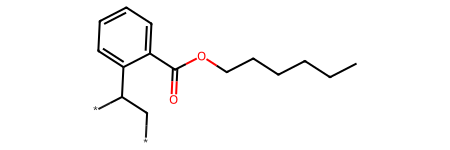

In [1]:
import pandas as pd
full_train_data = pd.read_csv("../data/train.csv")
valid_ffv = full_train_data[full_train_data['FFV'].notna()]

two_star_ffv = valid_ffv[valid_ffv['SMILES'].str.count(r"\*") == 2]

from data_gen_helpers import display_smiles
sample_smiles = two_star_ffv.loc[0, 'SMILES']

display_smiles(sample_smiles)

In [77]:
import pickle
import gzip

if 'matching_dataset' not in locals():
    matching_dataset = []
if not matching_dataset:
    file_path = "../data/vae_github_data/dataset_train_fc.pkl.gz"
    with gzip.open(file_path, "rb") as f:
        matching_dataset = pickle.load(f)

print(type(matching_dataset[0]))
print(matching_dataset[0]['x'])
print(matching_dataset[0]['edge_index'])

<class 'torch_geometric.data.data.Data'>
tensor([[ 1,  0,  1,  0,  0,  0],
        [ 1,  0,  1,  0,  0,  0],
        [ 1,  0,  0,  1,  0,  0],
        [ 1,  0,  1,  0,  0,  0],
        [ 1,  0,  0,  1,  0,  0],
        [ 1,  0,  0,  1,  0,  0],
        [ 1,  0,  1,  0,  0,  0],
        [ 1,  0,  1,  0,  0,  0],
        [ 1,  0,  0,  1,  0,  0],
        [-1,  0,  1,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  0,  0,  1,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  0,  0,  1,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  0,  0,  1,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
       

In [74]:
from dataset_helpers import *

print(minimal_orbital_token(24))
print(minimal_orbital_token(46))
print(minimal_orbital_token(113))
print(minimal_orbital_token(6))
print(minimal_orbital_token(1, include_star_dim=True))  # Hydrogen
print(minimal_orbital_token(-4, include_star_dim=True))

tensor([4., 1., 4., 5., 0.])
tensor([ 5.,  0.,  6., 10.,  0.])
tensor([ 7.,  2.,  1., 10., 14.])
tensor([2., 2., 2., 0., 0.])
tensor([1., 1., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 1.])


In [73]:
two_star_ffv_graph_data = smiles_iter_to_graph_dataset(two_star_ffv.SMILES)

save_dataset(two_star_ffv_graph_data, '../data/working_datasets/two_star_include_stars')

In [ ]:
# https://github.com/mcunow/graph-matching/blob/main/src/vgae.py
from torch.nn import Module
from torch_geometric.nn import Set2Set, AttentionalAggregation
from torch_geometric.nn.inits import reset
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling, dropout_edge, dropout_node, from_smiles, to_smiles, to_rdmol, from_rdmol
import torch.nn.functional as F

class GAE(Module):
